In [1]:
import os
import os.path as path
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

Using TensorFlow backend.


In [2]:
hyperparams = {
    'v': 10000,  # Vocabulary length of the top v words
    'n': 100,    # All reviews will be 100 words long, chop of longer ones and pad the shorter ones
    'd': 100,    # Dimensionality of the embeddings
    'm': 200     # The number of training samples to consider
}

In [3]:
def load_imdb():
    """
    Download the full IMDB review corpus from ai.stanford.edu/~amaas/data/sentiment/ and extract it to /data/learn-keras/aclImdb. It has a total
    of 50,000 reviews, divided equally between test and train directories. There are an equal number of positive and negative reviews, again in
    directories named pos and neg respectively. We will be using only train data.
    """
    dataroot = '/data/learn-keras/aclImdb/train'
    labels = []
    reviews = []
    classifications = {'neg': 0, 'pos': 1}
    for label, target in classifications.items():
        datadir = path.join(dataroot, label)
        for fname in os.listdir(datadir):
            if fname[-4:] == '.txt':
                fpath = path.join(datadir, fname)
                with open(fpath, 'rt') as f:
                    reviews.append(f.read())
                labels.append(target)
    labels = np.array(labels)
    return reviews, labels

In [4]:
tmp_reviews, tmp_labels = load_imdb()
print(tmp_reviews[0], tmp_labels[0])
print(tmp_reviews[-1], tmp_labels[-1])

Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly. 0
Working-class romantic drama from director Martin Ritt is as unbelievable as they come, yet there are moments of pleasure due mostly to the charisma of stars Jane Fonda and Robert De Niro (both terrific). She's a widow who can't move on, he's illiterate and a closet-inventor--you can probably guess the rest. Adaptation of Pat Barker's novel

Tokenize will first convert words into tokens taking care to convert everything to lowercase, ignoring punctuation, etc. It will then replace each document with its corresponding word vector. When building the word vector it will discard any word that is not part of the vocabulary. So the resulting word vector may have less number of elements than the number of tokens in the original document.

Then we pad/truncate each word vector such that all vectors are of the same length *n*. For vectors that are smaller than *n*, zeros are padded in the front. For vectors that are longer than *n*, elements are chopped off from the head.

Notice how the first review has 112 words. The corresponding raw vector also has 112 elements with a bunch of elements being more than 10,000, which means that these are tokens that are not amongst the top 10,000 tokens and should be discarded. Correspondingly the vector returned by the Tokenizer has 104 elements and all the elements > 10,000 have been dropped. The padded vector is even smaller at 100, with the first 4 elements dropped.

In [5]:
def tokenize(reviews):
    tokenizer = Tokenizer(num_words=hyperparams['v'])
    tokenizer.fit_on_texts(reviews)
    vectors = tokenizer.texts_to_sequences(reviews)
    indexes = tokenizer.word_index
    tokens = {index: token for token, index in indexes.items()}
    return indexes, tokens, vectors

def pad(vectors):
    return pad_sequences(vectors, maxlen=hyperparams['n'])

In [6]:
# tmp_reviews, tmp_labels = load_imdb()
tmp_indexes, tmp_tokens, tmp_vectors = tokenize(tmp_reviews)
tmp_padded_vectors = pad(tmp_vectors)

tmp_review = tmp_reviews[0]
tmp_vector = tmp_vectors[0]
tmp_padded_vector = tmp_padded_vectors[0]
tmp_raw_vector = []
for word in tmp_review.split():
    word = word.lower()
    if word.endswith('.'):
        word = word[:-1]
    index = tmp_indexes.get(word, -1)
    tmp_raw_vector.append(index)
tmp_raw_vector = np.array(tmp_raw_vector)
print('\n')
print(len(tmp_review.split()), tmp_review)
print(len(tmp_raw_vector), tmp_raw_vector)
print(len(tmp_vector), np.array(tmp_vector))
print(len(tmp_padded_vector), tmp_padded_vector)



112 Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.
112 [   62     4     3   129    34    44  7576  1414    15     3  4252   514
    43    16     3   633   133    12     6     3  1301   459     4  1751
   209     3 10785  7693   308     6   676    80    32    -1  1110  3008
    31     1   929 52007     4    42  5120   469     9  2665  1751     1
   223    55    16    54   828  1318   847

In [7]:
def shuffle(vectors, targets):
    indices = np.arange(vectors.shape[0])
    np.random.shuffle(indices)
    return vectors[indices], targets[indices]

def get_train_val(vectors, targets):
    val_size = 10000
    m = hyperparams['m']
    return (vectors[:m], targets[:m]), (vectors[m:val_size], targets[m:val_size])

In [8]:
# tmp_reviews, tmp_labels = load_imdb()
# tmp_indexes, tmp_tokens, tmp_vectors = tokenize(tmp_reviews)
# tmp_padded_vectors = pad(tmp_vectors)
tmp_shuffled_padded_vectors, tmp_shuffled_labels = shuffle(tmp_padded_vectors, tmp_labels)
(tmp_x_train, tmp_y_train), (tmp_x_test, tmp_y_test) = get_train_val(tmp_shuffled_padded_vectors, tmp_shuffled_labels)
print(tmp_x_train.shape, tmp_x_test.shape)

(200, 100) (9800, 100)


Load the Glove embeddings. This is exactly the same code in Embeddings notebook. Look for explanation there.

In [9]:
def load_embeddings_matrix(indexes):
    v = hyperparams['v']
    d = hyperparams['d']
    
    embeddings_indexes = {}
    with open(f'/data/learn-keras/glove.6B.{d}d.txt', 'rt') as f:
        for line in f:
            flds = line.split()
            word = flds[0]
            embeddings_vec = np.array(flds[1:], dtype=np.float32)
            embeddings_indexes[word] = embeddings_vec
            
    embeddings_matrix = np.zeros((v, d))
    words_no_embeddings = []
    for word, index in indexes.items():
        if index < v:
            if word in embeddings_indexes:
                embeddings_vec = embeddings_indexes[word]
                embeddings_matrix[index] = embeddings_vec
            else:
                words_no_embeddings.append(word)
    print(f'Unable to find embeddings for {len(words_no_embeddings)} words')
    print(words_no_embeddings[:10])
    return embeddings_matrix

In [10]:
# tmp_reviews, tmp_labels = load_imdb()
# tmp_indexes, tmp_tokens, tmp_vectors = tokenize(tmp_reviews)
tmp_mat = load_embeddings_matrix(tmp_indexes)
tmp_mat[tmp_indexes['the']]

Unable to find embeddings for 199 words
["it's", "don't", "i'm", "doesn't", "didn't", "can't", "that's", "i've", "isn't", "there's"]


array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

Design the model. Again exact same model as that described in Embeddings notebook.

In [11]:
def design_model(embeddings_matrix):
    v = hyperparams['v']
    d = hyperparams['d']
    n = hyperparams['n']
    model = Sequential()
    model.add(Embedding(v, d, input_shape=(n,)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.layers[0].set_weights([embeddings_matrix])
    model.layers[0].trainable = False
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

In [12]:
# tmp_reviews, tmp_labels = load_imdb()
# tmp_indexes, tmp_tokens, tmp_vectors = tokenize(tmp_reviews)
# tmp_mat = load_embeddings_matrix(tmp_indexes)
tmp_model = design_model(tmp_mat)
tmp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 1,010,001
Trainable params: 10,001
Non-trainable params: 1,000,000
_________________________________________________________________


Run the entire process

In [15]:
reviews, labels = load_imdb()
indexes, tokens, vectors = tokenize(reviews)
vectors = pad(vectors)
vectors, labels = shuffle(vectors, labels)
(x_train, y_train), (x_val, y_val) = get_train_val(vectors, labels)
embeddings_matrix = load_embeddings_matrix(indexes)
model = design_model(embeddings_matrix)
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Unable to find embeddings for 199 words
["it's", "don't", "i'm", "doesn't", "didn't", "can't", "that's", "i've", "isn't", "there's"]
Train on 200 samples, validate on 9800 samples
Epoch 1/10
200/200 [==============================] - 0s - loss: 1.1920 - acc: 0.4500 - val_loss: 0.7111 - val_acc: 0.5383
Epoch 2/10
200/200 [==============================] - 0s - loss: 0.5359 - acc: 0.7700 - val_loss: 0.7090 - val_acc: 0.5467
Epoch 3/10
200/200 [==============================] - 0s - loss: 0.3722 - acc: 0.8650 - val_loss: 0.8336 - val_acc: 0.5150
Epoch 4/10
200/200 [==============================] - 0s - loss: 0.3898 - acc: 0.8400 - val_loss: 0.7228 - val_acc: 0.5515
Epoch 5/10
200/200 [==============================] - 0s - loss: 0.2281 - acc: 0.9650 - val_loss: 0.7110 - val_acc: 0.5616
Epoch 6/10
200/200 [==============================] - 0s - loss: 0.1797 - acc: 1.0000 - val_loss: 0.8085 - val_acc: 0.5364
Epoch 7/10
200/200 [==============================] - 0s - loss: 0.1725 - acc: 0.9

In [16]:
model.save_weights('pre_trained_glove_model.h5')

In [19]:
import utils

utils.plot(history)

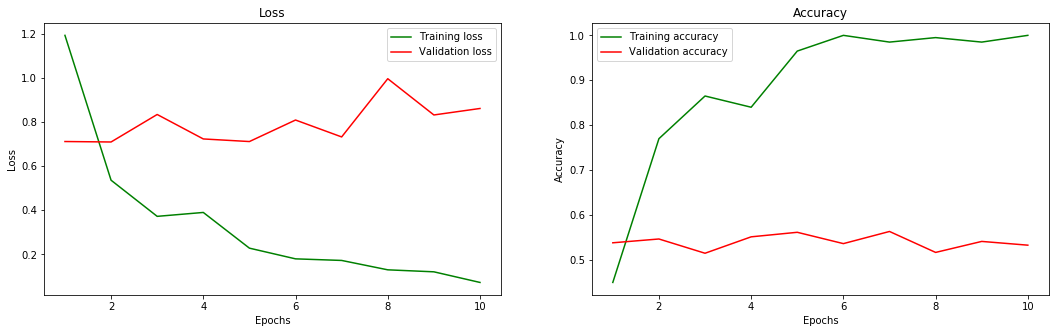

In [20]:
plt.show()